In [1]:
#STEP 1: DATA COLLECTION

In [2]:
#Pandas is a Python library used for working with data sets. 
#It has functions for analyzing, cleaning, exploring, and manipulating data. 
#The name "Pandas" has a reference to both "Panel Data", 
#and "Python Data Analysis" and was created by Wes McKinney in 2008

In [3]:
import pandas as pd
from string import ascii_uppercase as capalpha

#pickle used to binarize the data and save it
import pickle

all_tables = pd.read_html('https://en.wikipedia.org/wiki/2014_FIFA_World_Cup')
all_tables_2022 = pd.read_html('https://en.wikipedia.org/wiki/2022_FIFA_World_Cup')

dict_table={}
for letter, i in zip(capalpha, range(10,66,7)):
    df = all_tables[i]
    df.rename(columns = {df.columns[1]: 'Team'}, inplace = True)
    dict_table[f'Group {letter}'] = df

dict_table_2022={}
for letter, i in zip(capalpha, range(9,65,7)):
    df = all_tables_2022[i]
    df.rename(columns = {df.columns[1]: 'Team'}, inplace = True)
    dict_table_2022[f'Group {letter}'] = df

with open('dict_table','wb') as output:
    pickle.dump(dict_table, output)




In [4]:
#TILL Here we have created a savedata file. 

In [5]:
#Here on wards we scrap the actual and complete required data

In [6]:
%pip install bs4
%pip install requests
import requests
import lxml

import re
#BeautifulSoup is used to scrap the website. done through bs4 library
from bs4 import BeautifulSoup


link='https://en.wikipedia.org/wiki/2022_FIFA_World_Cup'

#requests used to get the HTML requests
response = requests.get(link)
content= response.text
soup = BeautifulSoup(content, 'lxml')

#The systax for soup is: soup.find_all('TAG', class_name='Classname')
#The below code to get all the matches from the soup above
AllMatches = soup.find_all('div', class_='footballbox')

#Here, we are getting all the names of the matches, home, score, and away
homeTeam = []
score = []
awayTeam = []
dates = []
times = []
penalties = []
for match in AllMatches:
    homeTeam.append(match.find('th', class_='fhome').get_text())
    score.append(match.find('th', class_='fscore').get_text())
    awayTeam.append(match.find('th', class_='faway').get_text())

    # Find all 'tr' elements with class 'fgoals' within the match
    penalties_rows = match.find_all('tr', class_='fgoals')
    # Extract text from 'th' elements within each 'tr' element separately
    penalties_data = []
    for row in penalties_rows:
        th_element = row.find('th')
        if th_element:
            penalties_data.append(th_element.get_text())
    penalties.append(penalties_data)
    
    # Extract the combined datetime string
    datetime_str = match.find('div', class_='fleft').get_text()    
    # Use regular expressions to split date and time
    date_match = re.search(r'(\d{1,2}\s\w{3,}\s\d{4})', datetime_str)
    time_match = re.search(r'(\d{2}:\d{2})', datetime_str) 
    if date_match and time_match:
        date = date_match.group(0)
        time = time_match.group(0)
        dates.append(f"{date}")
        times.append(f"{time}")
    else:
        dates.append(" ")
        times.append(" ")  # Handle cases where date or time is missing

#We will create a dictionary to store these matches first, then create a DataFrame
dict_allmatches = {'HomeTeam': homeTeam,'Score':score,'AwayTeam':awayTeam,'Penalties':penalties, 'Date':dates, 'Time':times,}

#I have created a DF with year, and matches
df_allmatches = pd.DataFrame(dict_allmatches)
df_allmatches['Year'] = '2022'

#Converting Penalties column to usable data:
df_allmatches['Penalties'] = df_allmatches['Penalties'].apply(str)
penalties_expanded = df_allmatches['Penalties'].str.split('',expand=True)
penalties_expanded = penalties_expanded.iloc[:,3:6]
penalties_expanded.columns = ['Home Pens','vs','Away Pens']
penalties_expanded = penalties_expanded.drop(['vs'], axis = 1)
df_allmatches = pd.concat([df_allmatches, penalties_expanded], axis=1)
df_allmatches = df_allmatches.drop(['Penalties'], axis = 1)

df_allmatches

#The above data is the data of the 2022 Fixtures
df_allmatches.to_csv('Correct_Fixture_Data_2022.csv', index=False)

Note: you may need to restart the kernel to use updated packages.



In [7]:
#The above format is the format of data that I want to get throughout the date, to get the right conclusions.

In [8]:
#Here I will create a function to get the data from all Worldcup tournaments
#Here we will find a pattern of HTML links of all the worldcups, so we can get data 
#directly through the function.
#I will leave the year 2014 as it is, and copy the code in get_allmatches function for 
#all other worldcups. Thus automating the data collection process.
#The below code gets all the matches for all the world cups. A good peice of code
def get_allmatches(year):
    link = f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'
    response = requests.get(link)
    content= response.text
    soup = BeautifulSoup(content, 'lxml')

    AllMatches = soup.find_all('div', class_='footballbox')

    homeTeam = []
    score = []
    awayTeam = []
    dates = []
    times = []
    penalties = []
    for match in AllMatches:
        homeTeam.append(match.find('th', class_='fhome').get_text())
        score.append(match.find('th', class_='fscore').get_text())
        awayTeam.append(match.find('th', class_='faway').get_text())

        # Find all 'tr' elements with class 'fgoals' within the match
        penalties_rows = match.find_all('tr', class_='fgoals')
        # Extract text from 'th' elements within each 'tr' element separately
        penalties_data = []
        for row in penalties_rows:
            th_element = row.find('th')
            if th_element:
                penalties_data.append(th_element.get_text())
        penalties.append(penalties_data)
        
        # Extract the combined datetime string
        datetime_str = match.find('div', class_='fleft').get_text()    
        # Use regular expressions to split date and time
        date_match = re.search(r'(\d{1,2}\s\w{3,}\s\d{4})', datetime_str)
        time_match = re.search(r'(\d{2}:\d{2})', datetime_str) 
        if date_match and time_match:
            date = date_match.group(0)
            time = time_match.group(0)
            dates.append(f"{date}")
            times.append(f"{time}")
        else:
            dates.append(" ")
            times.append(" ")  # Handle cases where date or time is missing
        
    dict_allmatches = {'HomeTeam': homeTeam,'Score':score,'AwayTeam':awayTeam,'Penalties':penalties, 'Date':dates, 'Time':times}
    df_allmatches = pd.DataFrame(dict_allmatches)
    df_allmatches['Year'] = year
    
    return df_allmatches

#I will create a comprehension list of all the matches of all tournaments. 
#E.g of comprehension:
#list = [i for i in range(11) if i % 2 == 0]
#print(list)

worldcup_years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022] 
fifa = [get_allmatches(year) for year in worldcup_years]

#Concat all the tables/years in the fifa dataframe. Thus completing Data Collection.
#This final data frame will be further used in the next process 
#of the Data Analysis: Data cleaning
df_Fifa = pd.concat(fifa, ignore_index=True)

#you can test if all data is present by using head and tail function
print(df_Fifa.head())
df_Fifa.tail()

#Now, we will be downloading the data to perform DATA CLEANING in other tools.
#The format we download the data is in CSV format
df_Fifa.to_csv('Total_Fifa_Matches_Data_Update.csv',index=False)

     HomeTeam Score AwayTeam Penalties          Date   Time  Year
0     France    4–1   Mexico        []  13 July 1930  15:00  1930
1  Argentina    1–0   France        []  15 July 1930  16:00  1930
2      Chile    3–0   Mexico        []  16 July 1930  14:45  1930
3      Chile    1–0   France        []  19 July 1930  12:50  1930
4  Argentina    6–3   Mexico        []  19 July 1930  15:00  1930


In [9]:
#STEP 2: DATA CLEANING

In [10]:
df_allData = pd.read_csv('Total_Fifa_Matches_Data_Update.csv')

In [11]:
#Cleaning names, by removing spaces
df_allData['HomeTeam']=df_allData['HomeTeam'].str.strip()
df_allData['AwayTeam']=df_allData['AwayTeam'].str.strip()
df_allData['Score']=df_allData['Score'].str.strip()

#Missing data to be cleaned
#dropping null values:
df_allData.dropna(inplace=True)
df_allData[df_allData['Score'].isnull()]

#Drop duplicates:
df_allData.drop_duplicates()

#Sorting acc. to year
df_allData.sort_values('Year', inplace=True)

#deleting matchs with walk overs
df_allData[df_allData['HomeTeam'].str.contains('Sweden') & df_allData['AwayTeam'].str.contains('Austria')]
delete_index = df_allData[df_allData['HomeTeam'].str.contains('Sweden') & df_allData['AwayTeam'].str.contains('Austria')].index

df_allData.drop(index=delete_index, inplace=True)

#after droping the walk overs
df_allData[df_allData['HomeTeam'].str.contains('Sweden') & df_allData['AwayTeam'].str.contains('Austria')]

#column scores with digits only:
df_allData[df_allData['Score'].str.contains('[^\d-]')]

df_allData['Score'] = df_allData['Score'].str.replace('[^\d-]',' ', regex=True)

#After cleaning
df_allData[df_allData['Score'].str.contains('[^\d-]')]

#Splitting score columns to home and away team goals and drop score column
df_allData.head()

#Splitting score columns to home and away team goals and dropping unwanted columns
score_split_all = df_allData['Score'].str.split('',expand=True)
score_split_all = score_split_all.iloc[:, :4]

#Rename the columns
score_split_all.columns = ['--1','Home Team Goals', '--2', 'Away Team Goals']

#Concatenate the split columns to the original DataFrame
df_allData = pd.concat([df_allData, score_split_all], axis=1)

#Drop the 'Score' column
df_allData = df_allData.drop(['--1','--2','Score'], axis= 1)

#corrected columns and data 
df_allData

#changing data types to proper ones
#df_allData = df_allData.astype({'Year': int,'Home Team Goals':int, 'Away Team Goals':int})
# Convert the 'ColumnName' column to numeric, but handle non-convertible values with a try-except block
def convert_to_int(val):
    try:
        return int(val)
    except (ValueError, TypeError):
        return 0  # Replace non-convertible values with a default value (e.g., 0)

df_allData['Away Team Goals'] = df_allData['Away Team Goals'].apply(convert_to_int).astype(int)
df_allData['Home Team Goals'] = df_allData['Home Team Goals'].apply(convert_to_int).astype(int)

#Creating a total goals column
df_allData['Total Goals Scored'] = df_allData['Home Team Goals']+df_allData['Away Team Goals']

df_allData.to_csv('Cleaned_All_Fifa_WorldCup_Data_Update.csv', index=False)
df_allData

,HomeTeam,AwayTeam,Penalties,Date,Time,Year,Home Team Goals,Away Team Goals,Total Goals Scored
0,France,Mexico,[],13 July 1930,15:00,1930,4,1,5
17,Uruguay,Argentina,[],30 July 1930,12:45,1930,4,2,6
16,Uruguay,Yugoslavia,[],27 July 1930,14:45,1930,6,1,7
15,Argentina,United States,[],26 July 1930,14:45,1930,6,1,7
14,Paraguay,Belgium,[],20 July 1930,15:00,1930,1,0,1
...,...,...,...,...,...,...,...,...,...
891,Japan,Costa Rica,[],27 November 2022,13:00,2022,0,1,1
892,Spain,Germany,[],27 November 2022,22:00,2022,1,1,2
893,Japan,Spain,[],1 December 2022,22:00,2022,2,1,3
895,Morocco,Croatia,[],23 November 2022,13:00,2022,0,0,0


In [12]:
#We got all the worldcups data till 2018. Here on, we are working on 2022 data

In [13]:
#Creating a Fixture DF for 2022 WC

df_fixtures = pd.DataFrame()
df_fixtures = pd.read_csv('Correct_Fixture_Data_2022.csv')
df_fixtures

,HomeTeam,Score,AwayTeam,Date,Time,Year,Home Pens,Away Pens
0,Qatar,0–2,Ecuador,20 November 2022,19:00,2022,NaN,NaN
1,Senegal,0–2,Netherlands,21 November 2022,19:00,2022,NaN,NaN
2,Qatar,1–3,Senegal,25 November 2022,16:00,2022,NaN,NaN
3,Netherlands,1–1,Ecuador,25 November 2022,19:00,2022,NaN,NaN
4,Ecuador,1–2,Senegal,29 November 2022,18:00,2022,NaN,NaN
...,...,...,...,...,...,...,...,...
59,England,1–2,France,10 December 2022,22:00,2022,NaN,NaN
60,Argentina,3–0,Croatia,13 December 2022,22:00,2022,NaN,NaN
61,France,2–0,Morocco,14 December 2022,22:00,2022,NaN,NaN
62,Croatia,2–1,Morocco,17 December 2022,18:00,2022,NaN,NaN


In [14]:
#The data is totally cleaned for our problem statements, 
#now we will be proceeding to the next step, i.e., 
#Data Transformation

In [15]:
#I am making a copy of df_fixtures, because if I make a mistake, I have to rerun the whole code.
df_fixtures_copy = df_fixtures
#Splitting score columns to home and away team goals and dropping unwanted columns
score_split_fix = df_fixtures_copy['Score'].str.split('',expand=True)
score_split_fix = score_split_fix.iloc[:, :4]
score_split_fix

#Rename the columns
score_split_fix.columns = ['--1','Home Team Goals', '--2', 'Away Team Goals']
score_split_fix

#Concatenate the split columns to the original DataFrame
df_fixtures_copy = pd.concat([df_fixtures_copy, score_split_fix], axis=1)
#df_fixtures = df_fixtures.iloc[:64,:9]

In [16]:
df_fixtures_copy

,HomeTeam,Score,AwayTeam,Date,Time,Year,Home Pens,Away Pens,--1,Home Team Goals,--2,Away Team Goals
0,Qatar,0–2,Ecuador,20 November 2022,19:00,2022,NaN,NaN,,0,–,2
1,Senegal,0–2,Netherlands,21 November 2022,19:00,2022,NaN,NaN,,0,–,2
2,Qatar,1–3,Senegal,25 November 2022,16:00,2022,NaN,NaN,,1,–,3
3,Netherlands,1–1,Ecuador,25 November 2022,19:00,2022,NaN,NaN,,1,–,1
4,Ecuador,1–2,Senegal,29 November 2022,18:00,2022,NaN,NaN,,1,–,2
...,...,...,...,...,...,...,...,...,...,...,...,...
59,England,1–2,France,10 December 2022,22:00,2022,NaN,NaN,,1,–,2
60,Argentina,3–0,Croatia,13 December 2022,22:00,2022,NaN,NaN,,3,–,0
61,France,2–0,Morocco,14 December 2022,22:00,2022,NaN,NaN,,2,–,0
62,Croatia,2–1,Morocco,17 December 2022,18:00,2022,NaN,NaN,,2,–,1


In [17]:
df_fixtures_copy.dtypes
#Drop the 'Score' column
df_fixtures_copy = df_fixtures_copy.drop(['--1','--2','Score'], axis= 1)

In [18]:
df_fixtures_copy

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals
0,Qatar,Ecuador,20 November 2022,19:00,2022,NaN,NaN,0,2
1,Senegal,Netherlands,21 November 2022,19:00,2022,NaN,NaN,0,2
2,Qatar,Senegal,25 November 2022,16:00,2022,NaN,NaN,1,3
3,Netherlands,Ecuador,25 November 2022,19:00,2022,NaN,NaN,1,1
4,Ecuador,Senegal,29 November 2022,18:00,2022,NaN,NaN,1,2
...,...,...,...,...,...,...,...,...,...
59,England,France,10 December 2022,22:00,2022,NaN,NaN,1,2
60,Argentina,Croatia,13 December 2022,22:00,2022,NaN,NaN,3,0
61,France,Morocco,14 December 2022,22:00,2022,NaN,NaN,2,0
62,Croatia,Morocco,17 December 2022,18:00,2022,NaN,NaN,2,1


In [19]:
#Now that the code has worked and df_fixtures_copy looks like I the format of data I wanted, I can assign it back to df_fixtures:
df_fixtures = df_fixtures_copy

In [20]:
df_fixtures

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals
0,Qatar,Ecuador,20 November 2022,19:00,2022,NaN,NaN,0,2
1,Senegal,Netherlands,21 November 2022,19:00,2022,NaN,NaN,0,2
2,Qatar,Senegal,25 November 2022,16:00,2022,NaN,NaN,1,3
3,Netherlands,Ecuador,25 November 2022,19:00,2022,NaN,NaN,1,1
4,Ecuador,Senegal,29 November 2022,18:00,2022,NaN,NaN,1,2
...,...,...,...,...,...,...,...,...,...
59,England,France,10 December 2022,22:00,2022,NaN,NaN,1,2
60,Argentina,Croatia,13 December 2022,22:00,2022,NaN,NaN,3,0
61,France,Morocco,14 December 2022,22:00,2022,NaN,NaN,2,0
62,Croatia,Morocco,17 December 2022,18:00,2022,NaN,NaN,2,1


In [21]:
#changing data types to proper ones
#df_allData = df_allData.astype({'Year': int,'Home Team Goals':int, 'Away Team Goals':int})
# Convert the 'ColumnName' column to numeric, but handle non-convertible values with a try-except block
def convert_to_int(val):
    try:
        return int(val)
    except (ValueError, TypeError):
        return 0  # Replace non-convertible values with a default value (e.g., 0)

df_fixtures['Away Team Goals'] = df_fixtures['Away Team Goals'].apply(convert_to_int).astype(int)
df_fixtures['Home Team Goals'] = df_fixtures['Home Team Goals'].apply(convert_to_int).astype(int)

#Creating a total goals column
df_fixtures['Total Goals Scored'] = df_fixtures['Home Team Goals']+df_fixtures['Away Team Goals']
df_fixtures.to_csv('Cleaned_Fifa_WorldCup_2022_Update.csv',index=False)

In [22]:
df_fixtures

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored
0,Qatar,Ecuador,20 November 2022,19:00,2022,NaN,NaN,0,2,2
1,Senegal,Netherlands,21 November 2022,19:00,2022,NaN,NaN,0,2,2
2,Qatar,Senegal,25 November 2022,16:00,2022,NaN,NaN,1,3,4
3,Netherlands,Ecuador,25 November 2022,19:00,2022,NaN,NaN,1,1,2
4,Ecuador,Senegal,29 November 2022,18:00,2022,NaN,NaN,1,2,3
...,...,...,...,...,...,...,...,...,...,...
59,England,France,10 December 2022,22:00,2022,NaN,NaN,1,2,3
60,Argentina,Croatia,13 December 2022,22:00,2022,NaN,NaN,3,0,3
61,France,Morocco,14 December 2022,22:00,2022,NaN,NaN,2,0,2
62,Croatia,Morocco,17 December 2022,18:00,2022,NaN,NaN,2,1,3


In [23]:
#STEP 3: DATA TRANSFORMATION

In [24]:
#df_allData.to_csv('Fifa_All_WorldCup_Data.csv',index=False)
df_allData.dtypes
# Assuming you want to convert the 'ColumnName' column to a string
df_allData['Date'] = df_allData['Date'].astype(str)

In [25]:
%pip install scipy
from scipy.stats import poisson
import pickle
df_fixtures = pd.read_csv('Cleaned_Fifa_WorldCup_2022_Update.csv')
dict_table = pickle.load(open('dict_table','rb'))
df_allData = pd.read_csv('Cleaned_All_Fifa_WorldCup_Data_Update.csv')
dict_table['Group A']

#Split the data to df_home and df_away 
df_home = df_allData[['HomeTeam','Home Team Goals','Away Team Goals']]
df_away = df_allData[['AwayTeam','Home Team Goals','Away Team Goals']]

#Renaming columns
df_home = df_home.rename(columns={'HomeTeam': 'Team','Home Team Goals':'GoalsScored','Away Team Goals':'GoalsConceded'})
df_away = df_away.rename(columns={'AwayTeam': 'Team','Home Team Goals':'GoalsConceded','Away Team Goals':'GoalsScored'})

df_home.tail()

#concat df_home and df_away, group by team and calculate the mean, thus getting the strength of the team.
df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby('Team').mean()
df_team_strength

Note: you may need to restart the kernel to use updated packages.


,GoalsScored,GoalsConceded
Team,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.752941,1.164706
Australia,0.850000,1.850000
Austria,1.576923,1.692308
...,...,...
Uruguay,1.553571,1.303571
Wales,0.625000,1.250000
West Germany,2.050847,1.254237


In [26]:
dict_table_2022

{'Group A':    Pos         Team  Pld  W  D  L  GF  GA  GD  Pts               Qualification
 0    1  Netherlands    3  2  1  0   5   1  +4    7  Advanced to knockout stage
 1    2      Senegal    3  2  0  1   5   4  +1    6  Advanced to knockout stage
 2    3      Ecuador    3  1  1  1   4   3  +1    4                         NaN
 3    4    Qatar (H)    3  0  0  3   1   7  −6    0                         NaN,
 'Group B':    Pos           Team  Pld  W  D  L  GF  GA  GD  Pts  \
 0    1        England    3  2  1  0   9   2  +7    7   
 1    2  United States    3  1  2  0   2   1  +1    5   
 2    3           Iran    3  1  0  2   4   7  −3    3   
 3    4          Wales    3  0  1  2   1   6  −5    1   
 
                 Qualification  
 0  Advanced to knockout stage  
 1  Advanced to knockout stage  
 2                         NaN  
 3                         NaN  ,
 'Group C':    Pos          Team  Pld  W  D  L  GF  GA  GD  Pts  \
 0    1     Argentina    3  2  0  1   5   2  +3    6   
 

In [27]:
df_fixtures

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored
0,Qatar,Ecuador,20 November 2022,19:00,2022,NaN,NaN,0,2,2
1,Senegal,Netherlands,21 November 2022,19:00,2022,NaN,NaN,0,2,2
2,Qatar,Senegal,25 November 2022,16:00,2022,NaN,NaN,1,3,4
3,Netherlands,Ecuador,25 November 2022,19:00,2022,NaN,NaN,1,1,2
4,Ecuador,Senegal,29 November 2022,18:00,2022,NaN,NaN,1,2,3
...,...,...,...,...,...,...,...,...,...,...
59,England,France,10 December 2022,22:00,2022,NaN,NaN,1,2,3
60,Argentina,Croatia,13 December 2022,22:00,2022,NaN,NaN,3,0,3
61,France,Morocco,14 December 2022,22:00,2022,NaN,NaN,2,0,2
62,Croatia,Morocco,17 December 2022,18:00,2022,NaN,NaN,2,1,3


In [28]:
#The data was sorted in date and time form here
filtered_data = df_fixtures

filtered_data['Date'] = pd.to_datetime(filtered_data['Date'], format='%d %B %Y')
filtered_data['Time'] = pd.to_datetime(filtered_data['Time'], format='%H:%M').dt.time

filtered_data = filtered_data.sort_values(by=['Date', 'Time'], ascending=[True, True])
filtered_data = filtered_data.reset_index(drop=True)
filtered_data


,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored
0,Qatar,Ecuador,2022-11-20,19:00:00,2022,NaN,NaN,0,2,2
1,England,Iran,2022-11-21,16:00:00,2022,NaN,NaN,6,2,8
2,Senegal,Netherlands,2022-11-21,19:00:00,2022,NaN,NaN,0,2,2
3,United States,Wales,2022-11-21,22:00:00,2022,NaN,NaN,1,1,2
4,Argentina,Saudi Arabia,2022-11-22,13:00:00,2022,NaN,NaN,1,2,3
...,...,...,...,...,...,...,...,...,...,...
59,England,France,2022-12-10,22:00:00,2022,NaN,NaN,1,2,3
60,Argentina,Croatia,2022-12-13,22:00:00,2022,NaN,NaN,3,0,3
61,France,Morocco,2022-12-14,22:00:00,2022,NaN,NaN,2,0,2
62,Croatia,Morocco,2022-12-17,18:00:00,2022,NaN,NaN,2,1,3


In [29]:
#splitting fixtures to stages of the tournaments
#One is for Actual, and other is for predictive. For knockout, quarter, it is created near the PREDICTIVE code itself.
df_fixture_group = filtered_data[:48].copy()
df_fixture_knockout = filtered_data[48:56].copy()
df_fixture_quarter = filtered_data[56:60].copy()
df_fixture_semi = filtered_data[60:62].copy()
df_fixture_semi_predict_2 = filtered_data[60:62].copy()
df_fixture_final = filtered_data[62:].copy()
df_fixture_final_predict_2 = filtered_data[62:].copy()

In [30]:
#STEP 4: DATA PREDICTION

In [31]:
#we will use Poisson distribution to predict the winners. Poisson dist. is
#a discrete probability dist. that describes the number of events occuring
#in fixed time interval or region or opportunity. E.g., Events in 90 mins
# of football match. The assumptions for this to work are:
#1). The nubmer of events can be counted
#2). all events are independent of each other
#3). the rate of events through time is constant
#4). events cannot occur simultaneously
#Formula: P(X=x) = (lamda^x * e^(-lamda))/x!
#lamda = expected number of events(e.g., median of goals in 90 mins)
#x = number of goals in match that could be scored by Team A or B

In [32]:

def predict_points(home, away):
     if home in df_team_strength.index and away in df_team_strength.index:
         #goals_scored * goals_conceded
         lamda_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
         lamda_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
         prob_home,prob_away,prob_draw = 0,0,0
         #number of goals home team can score:
         for x in range(0,11):
             #number of goals away team can score:
             for y in range(0,11):
                 p = poisson.pmf(x,lamda_home) * poisson.pmf(y,lamda_away)
                 if x==y:
                     prob_draw +=p
                 elif x>y:
                     prob_home +=p
                 else:
                     prob_away +=p
         
         #using std points of the football leagues: 3 points for win, 1 point for draw
         points_home = (3 * prob_home) + prob_draw
         points_away = (3 * prob_away) + prob_draw
         return (points_home,points_away)
     #there may be some conditions where the above may not apply, so:
     else:
         return (0,0)
        

In [33]:
#Test the function with some matches:
predict_points('Argentina', 'Australia')

(2.533302603658306, 0.35016279850651466)

In [34]:
predict_points('England', 'United States')

(2.214691317172116, 0.6103287358099718)

In [35]:
predict_points('Qatar (H)','Ecuador')

(0, 0)

In [36]:
#Above, we dont have any historical data of the team QATAR, 
#being 2022 is the first tournament. 

In [37]:
#GROUP MATCHES ROUND

In [38]:
#run all the matches in the group stage and update group tables with rounded values
for group in dict_table_2022:
    teams_in_group = dict_table_2022[group]['Team'].values
    df_fixture_group_6 = df_fixture_group[df_fixture_group['HomeTeam'].isin(teams_in_group)]
    for index,row in df_fixture_group_6.iterrows():
        home,away = row['HomeTeam'],row['AwayTeam']
        points_home,points_away = predict_points(home,away)
        dict_table_2022[group].loc[dict_table_2022[group]['Team'] == home, 'Pts'] += points_home
        dict_table_2022[group].loc[dict_table_2022[group]['Team'] == home, 'Pts'] += points_away

    dict_table_2022[group] = dict_table_2022[group].sort_values('Pts', ascending=False).reset_index()
    dict_table_2022[group] = dict_table_2022[group][['Team','Pts']]
    dict_table_2022[group] = dict_table_2022[group].round(0)

#see the updated table: dict_table
dict_table_2022

{'Group A':           Team  Pts
 0  Netherlands    7
 1      Senegal    6
 2      Ecuador    4
 3    Qatar (H)    0,
 'Group B':             Team  Pts
 0        England    7
 1  United States    5
 2           Iran    3
 3          Wales    1,
 'Group C':            Team  Pts
 0     Argentina    6
 1        Poland    4
 2        Mexico    4
 3  Saudi Arabia    3,
 'Group D':         Team  Pts
 0     France    6
 1  Australia    6
 2    Tunisia    4
 3    Denmark    1,
 'Group E':          Team  Pts
 0       Japan    6
 1       Spain    4
 2     Germany    4
 3  Costa Rica    3,
 'Group F':       Team  Pts
 0  Morocco    7
 1  Croatia    5
 2  Belgium    4
 3   Canada    0,
 'Group G':           Team  Pts
 0       Brazil    6
 1  Switzerland    6
 2     Cameroon    4
 3       Serbia    1,
 'Group H':           Team  Pts
 0     Portugal    6
 1  South Korea    4
 2      Uruguay    4
 3        Ghana    3}

In [39]:
#KNOCKOUT ROUND

In [40]:
#ACTUAL START

#I am calculating/coding for existing match results, and not the for the unknown.
#Created a column Predicted_Winner in the knockout_out data
df_fixture_knockout['Predicted_winner'] = '?'
df_fixture_knockout

#Here, I am getting the Pridicted Winners, and not the actual winners, 
#that will be done in the next snippet of code
def get_predicted_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['HomeTeam'].strip(), row['AwayTeam'].strip()
        #earlier I was not getting the calculation because of the string output, so I had to add .strip()
        points_home, points_away = predict_points(home, away)
        
        if points_home > points_away:
            df_fixture_updated.at[index, 'Predicted_winner'] = home
        else:
            df_fixture_updated.at[index, 'Predicted_winner'] = away
            
    return df_fixture_updated

#Knockout rounds updated with predicted_results:
get_predicted_winner(df_fixture_knockout)

#Creating Actual winner column
df_fixture_knockout['Actual_winner'] = '?'
df_fixture_knockout

#Now I will insert the column called Actual_Winner:
def actual_winner(df_fixture_update):
    for index, row in df_fixture_update.iterrows():
        home, away = row['Home Team Goals'], row['Away Team Goals']
        homepens, awaypens = row['Home Pens'], row['Away Pens']
        home_name, away_name = row['HomeTeam'].strip(),row['AwayTeam'].strip()
        if home > away:
            df_fixture_update.at[index, 'Actual_winner'] = home_name
        elif home == away:
            if homepens > awaypens:
                df_fixture_update.at[index, 'Actual_winner'] = home_name
            else:
                df_fixture_update.at[index, 'Actual_winner'] = away_name
        else:
            df_fixture_update.at[index, 'Actual_winner'] = away_name
   
    return df_fixture_update

actual_winner(df_fixture_knockout)

#ACTUAL END

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner,Actual_winner
48,Netherlands,United States,2022-12-03,18:00:00,2022,NaN,NaN,3,1,4,Netherlands,Netherlands
49,Argentina,Australia,2022-12-03,22:00:00,2022,NaN,NaN,2,1,3,Argentina,Argentina
50,France,Poland,2022-12-04,18:00:00,2022,NaN,NaN,3,1,4,France,France
51,England,Senegal,2022-12-04,22:00:00,2022,NaN,NaN,3,0,3,England,England
52,Japan,Croatia,2022-12-05,18:00:00,2022,1.0,3.0,1,1,2,Croatia,Croatia
53,Brazil,South Korea,2022-12-05,22:00:00,2022,NaN,NaN,4,1,5,Brazil,Brazil
54,Morocco,Spain,2022-12-06,18:00:00,2022,3.0,0.0,0,0,0,Spain,Morocco
55,Portugal,Switzerland,2022-12-06,22:00:00,2022,NaN,NaN,6,1,7,Portugal,Portugal


In [41]:
df_fixture_quarter

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored
56,Croatia,Brazil,2022-12-09,18:00:00,2022,4.0,2.0,1,1,2
57,Netherlands,Argentina,2022-12-09,22:00:00,2022,3.0,4.0,2,2,4
58,Morocco,Portugal,2022-12-10,18:00:00,2022,NaN,NaN,1,0,1
59,England,France,2022-12-10,22:00:00,2022,NaN,NaN,1,2,3


In [42]:
#PREDICTIVE START

#I will create a new dataframe which will contain the winners and runnerups 
#from the all the groups and predict the winners from the formula, and not the actual one
data = {
    'HomeTeam': [
        'Winners Group A',
        'Winners Group C',
        'Winners Group D',
        'Winners Group B',
        'Winners Group E',
        'Winners Group G',
        'Winners Group F',
        'Winners Group H'
    ],
    'score': [
        'Match 49',
        'Match 50',
        'Match 52',
        'Match 51',
        'Match 53',
        'Match 54',
        'Match 55',
        'Match 56'
    ],
    'AwayTeam': [
        'Runners-up Group B',
        'Runners-up Group D',
        'Runners-up Group C',
        'Runners-up Group A',
        'Runners-up Group F',
        'Runners-up Group H',
        'Runners-up Group E',
        'Runners-up Group G'
    ],
    'year': [2022] * 8  # Assuming all entries are for the year 2022
}

# Create the DataFrame
#df_fixture_knockout_predict = pd.DataFrame(data)
df_fixture_knockout_predict_2 = pd.DataFrame(data)
# Optionally, reset the index (if you don't want the default index)
# df.reset_index(drop=True, inplace=True)

#The KnockoutRounds 
#The below piece of code is for fixtures not played yet, and to be calculated. This could be used in Future
for group in dict_table_2022:
    group_winner = dict_table_2022[group].loc[0, 'Team']
    runners_up = dict_table_2022[group].loc[1, 'Team']
    df_fixture_knockout_predict_2.replace({f'Winners {group}':group_winner,
                                 f'Runners-up {group}':runners_up}, inplace=True)

df_fixture_knockout_predict_2['Predicted_winner'] = '?'
df_fixture_knockout_predict_2
#The code is till here.

#Here, I am getting the Pridicted Winners,
def get_predicted_winner_future(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['HomeTeam'].strip(), row['AwayTeam'].strip()
        
        #earlier I was not getting the calculation because of the string output, so I had to add .strip()
        points_home, points_away = predict_points(home, away)

        if points_home > points_away:
            df_fixture_updated.at[index, 'Predicted_winner'] = home
        else:
            df_fixture_updated.at[index, 'Predicted_winner'] = away
          
    return df_fixture_updated

#Knockout rounds updated with predicted_results:
get_predicted_winner_future(df_fixture_knockout_predict_2)

#PREDICTIVE END

,HomeTeam,score,AwayTeam,year,Predicted_winner
0,Netherlands,Match 49,United States,2022,Netherlands
1,Argentina,Match 50,Australia,2022,Argentina
2,France,Match 52,Poland,2022,France
3,England,Match 51,Senegal,2022,England
4,Japan,Match 53,Croatia,2022,Croatia
5,Brazil,Match 54,South Korea,2022,Brazil
6,Morocco,Match 55,Spain,2022,Spain
7,Portugal,Match 56,Switzerland,2022,Portugal


In [43]:
#QUARTER FINAL ROUND

In [44]:
#ACTUAL START

#Created a column Predicted_Winner in the knockout_out data
df_fixture_quarter['Predicted_winner'] = '?'
df_fixture_quarter

#using the same Formula created above: get_predicted_winner for the ACTUAL Code:
get_predicted_winner(df_fixture_quarter)

#Creating Actual winner column
df_fixture_quarter['Actual_winner'] = '?'
df_fixture_quarter

#using actual winner formula created earlier: actual_winner
actual_winner(df_fixture_quarter)

#ACTUAL END

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner,Actual_winner
56,Croatia,Brazil,2022-12-09,18:00:00,2022,4.0,2.0,1,1,2,Brazil,Croatia
57,Netherlands,Argentina,2022-12-09,22:00:00,2022,3.0,4.0,2,2,4,Netherlands,Argentina
58,Morocco,Portugal,2022-12-10,18:00:00,2022,NaN,NaN,1,0,1,Portugal,Morocco
59,England,France,2022-12-10,22:00:00,2022,NaN,NaN,1,2,3,France,France


In [45]:
#PREDICTIVE START

df_fixture_quarter_predict_2 = filtered_data[56:60].copy()
def update_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'Predicted_winner']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
    df_fixture_round_2['Predicted_winner'] = '?'
    return df_fixture_round_2
    
update_table(df_fixture_knockout_predict_2, df_fixture_quarter_predict_2)

get_predicted_winner_future(df_fixture_quarter_predict_2)

#PREDICTIVE END

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner
56,Croatia,Brazil,2022-12-09,18:00:00,2022,4.0,2.0,1,1,2,Brazil
57,Netherlands,Argentina,2022-12-09,22:00:00,2022,3.0,4.0,2,2,4,Netherlands
58,Morocco,Portugal,2022-12-10,18:00:00,2022,NaN,NaN,1,0,1,Portugal
59,England,France,2022-12-10,22:00:00,2022,NaN,NaN,1,2,3,France


In [46]:
#SEMIFINALS:

In [47]:
#ACTUAL START

df_fixture_semi['Predicted_winner'] = '?'
df_fixture_semi

#using the same Formula created above: get_predicted_winner for the ACTUAL Code:
get_predicted_winner(df_fixture_semi)

#Creating Actual winner column
df_fixture_semi['Actual_winner'] = '?'
df_fixture_semi

#using actual winner formula created earlier: actual_winner
actual_winner(df_fixture_semi)

#ACTAUL END

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner,Actual_winner
60,Argentina,Croatia,2022-12-13,22:00:00,2022,NaN,NaN,3,0,3,Argentina,Argentina
61,France,Morocco,2022-12-14,22:00:00,2022,NaN,NaN,2,0,2,France,France


In [48]:
#PREDICTIVE START

update_table(df_fixture_knockout_predict_2, df_fixture_semi_predict_2)

get_predicted_winner_future(df_fixture_semi_predict_2)

#PREDICTIVE END

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner
60,Argentina,Croatia,2022-12-13,22:00:00,2022,NaN,NaN,3,0,3,Argentina
61,France,Morocco,2022-12-14,22:00:00,2022,NaN,NaN,2,0,2,France


In [49]:
#FINALS:

In [50]:
#ACTUAL START

df_fixture_final['Predicted_winner'] = '?'
df_fixture_final

get_predicted_winner(df_fixture_final)

#Creating Actual winner column
df_fixture_final['Actual_winner'] = '?'
df_fixture_final

#using actual winner formula created earlier: actual_winner
actual_winner(df_fixture_final)

#ACTUAL END

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner,Actual_winner
62,Croatia,Morocco,2022-12-17,18:00:00,2022,NaN,NaN,2,1,3,Croatia,Croatia
63,Argentina,France,2022-12-18,18:00:00,2022,4.0,2.0,3,3,6,France,Argentina


In [51]:
df_fixture_semi_predict_2

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner
60,Argentina,Croatia,2022-12-13,22:00:00,2022,NaN,NaN,3,0,3,Argentina
61,France,Morocco,2022-12-14,22:00:00,2022,NaN,NaN,2,0,2,France


In [52]:
#PREDICTIVE START

update_table(df_fixture_knockout_predict_2, df_fixture_final_predict_2)

get_predicted_winner_future(df_fixture_final_predict_2)

#PREDICTIVE END

,HomeTeam,AwayTeam,Date,Time,Year,Home Pens,Away Pens,Home Team Goals,Away Team Goals,Total Goals Scored,Predicted_winner
62,Croatia,Morocco,2022-12-17,18:00:00,2022,NaN,NaN,2,1,3,Croatia
63,Argentina,France,2022-12-18,18:00:00,2022,4.0,2.0,3,3,6,France


In [53]:
#Here ENDS the DATA ANALYSIS of Football Tournament. 

In [54]:
#NOW we will start the Visualizations:

In [55]:
#STEP 5: DATA VISUALISATION

In [56]:
# I will be using Seaborn and Matplotlib to begin with. I will mention the rest of the libraries used as I go along.

In [57]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
# nation_position, club_position, player_positions
df_players = pd.read_csv('players_22.csv', low_memory=False)


Note: you may need to restart the kernel to use updated packages.


In [58]:
# selecting column
df_players = df_players[['short_name', 'age', 'nationality_name', 'overall', 'potential',
         'club_name', 'value_eur', 'wage_eur', 'player_positions']]

# selecting only one position
df_players['player_positions'] = df_players['player_positions'].str.split(',', expand=True)[0]

# dropping nan
df_players.dropna(inplace=True)

In [59]:
df_players

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
0,L. Messi,34,Argentina,93,93,Paris Saint-Germain,78000000.0,320000.0,RW
1,R. Lewandowski,32,Poland,92,92,FC Bayern München,119500000.0,270000.0,ST
2,Cristiano Ronaldo,36,Portugal,91,91,Manchester United,45000000.0,270000.0,ST
3,Neymar Jr,29,Brazil,91,91,Paris Saint-Germain,129000000.0,270000.0,LW
4,K. De Bruyne,30,Belgium,91,91,Manchester City,125500000.0,350000.0,CM
...,...,...,...,...,...,...,...,...,...
19234,Song Defu,22,China PR,47,52,Wuhan FC,70000.0,1000.0,CDM
19235,C. Porter,19,Republic of Ireland,47,59,Derry City,110000.0,500.0,CM
19236,N. Logue,21,Republic of Ireland,47,55,Finn Harps,100000.0,500.0,CM
19237,L. Rudden,19,Republic of Ireland,47,60,Finn Harps,110000.0,500.0,ST


In [60]:
#players missing the worldcup due to non selection
players_missing_worldcup = ['K. Benzema', 'S. Mané', 'S. Agüero', 'Sergio Ramos', 'P. Pogba',
                            'M. Reus', 'Diogo Jota', 'A. Harit', 'N. Kanté', 'G. Lo Celso', 'Piqué']

# dropping injured players
drop_index = df_players[df_players['short_name'].isin(players_missing_worldcup)].index
df_players.drop(drop_index, axis=0, inplace=True)

In [61]:
#Teams participating in the worldcup
teams_worldcup = [
    'Qatar', 'Brazil', 'Belgium', 'France', 'Argentina', 'England', 'Spain', 'Portugal',
    'Mexico', 'Netherlands', 'Denmark', 'Germany', 'Uruguay', 'Switzerland', 'United States', 'Croatia',
    'Senegal', 'Iran', 'Japan', 'Morocco', 'Serbia', 'Poland', 'South Korea', 'Tunisia',
    'Cameroon', 'Canada', 'Ecuador', 'Saudi Arabia', 'Ghana', 'Wales', 'Costa Rica', 'Australia'
]

# filtering only national team players who are in the world cup
df_players = df_players[df_players['nationality_name'].isin(teams_worldcup)]

In [62]:
df_players

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
0,L. Messi,34,Argentina,93,93,Paris Saint-Germain,78000000.0,320000.0,RW
1,R. Lewandowski,32,Poland,92,92,FC Bayern München,119500000.0,270000.0,ST
2,Cristiano Ronaldo,36,Portugal,91,91,Manchester United,45000000.0,270000.0,ST
3,Neymar Jr,29,Brazil,91,91,Paris Saint-Germain,129000000.0,270000.0,LW
4,K. De Bruyne,30,Belgium,91,91,Manchester City,125500000.0,350000.0,CM
...,...,...,...,...,...,...,...,...,...
19183,F. Emmings,17,United States,48,73,Minnesota United FC,130000.0,500.0,GK
19197,J. Neal,17,United States,48,69,LA Galaxy,140000.0,500.0,CB
19216,H. Wiles-Richards,19,England,48,65,Bristol City,110000.0,1000.0,GK
19217,J. Affonso,23,Uruguay,48,55,Cerro Largo Fútbol Club,90000.0,500.0,CM


In [63]:
#Distribution of all players overall

D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


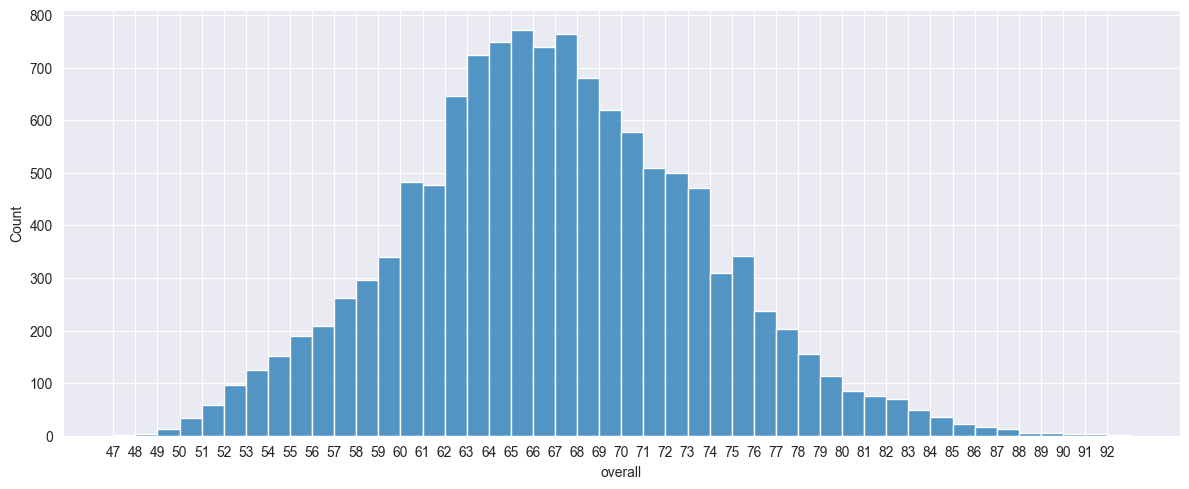

In [64]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

sns.histplot(df_players['overall'], binwidth=1)  # Use df['overall'] as the data to plot

bins = np.arange(df_players['overall'].min(), df_players['overall'].max(), 1)
plt.xticks(bins)
plt.show()

In [65]:
#best overall player for each position at the time of 2022 worldcup.

In [66]:
df_players.drop_duplicates('player_positions')
# viz -> https://trinket.io/python/0813ea96f6

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
0,L. Messi,34,Argentina,93,93,Paris Saint-Germain,78000000.0,320000.0,RW
1,R. Lewandowski,32,Poland,92,92,FC Bayern München,119500000.0,270000.0,ST
3,Neymar Jr,29,Brazil,91,91,Paris Saint-Germain,129000000.0,270000.0,LW
4,K. De Bruyne,30,Belgium,91,91,Manchester City,125500000.0,350000.0,CM
7,M. Neuer,35,Germany,90,90,FC Bayern München,13500000.0,86000.0,GK
14,Casemiro,29,Brazil,89,89,Real Madrid CF,88000000.0,310000.0,CDM
15,V. van Dijk,29,Netherlands,89,89,Liverpool,86000000.0,230000.0,CB
28,Bruno Fernandes,26,Portugal,88,89,Manchester United,107500000.0,250000.0,CAM
41,P. Dybala,27,Argentina,87,88,Juventus,93000000.0,160000.0,CF
44,T. Alexander-Arnold,22,England,87,92,Liverpool,114000000.0,150000.0,RB


In [67]:
#The most skillful player for each nation, and their comparison

D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


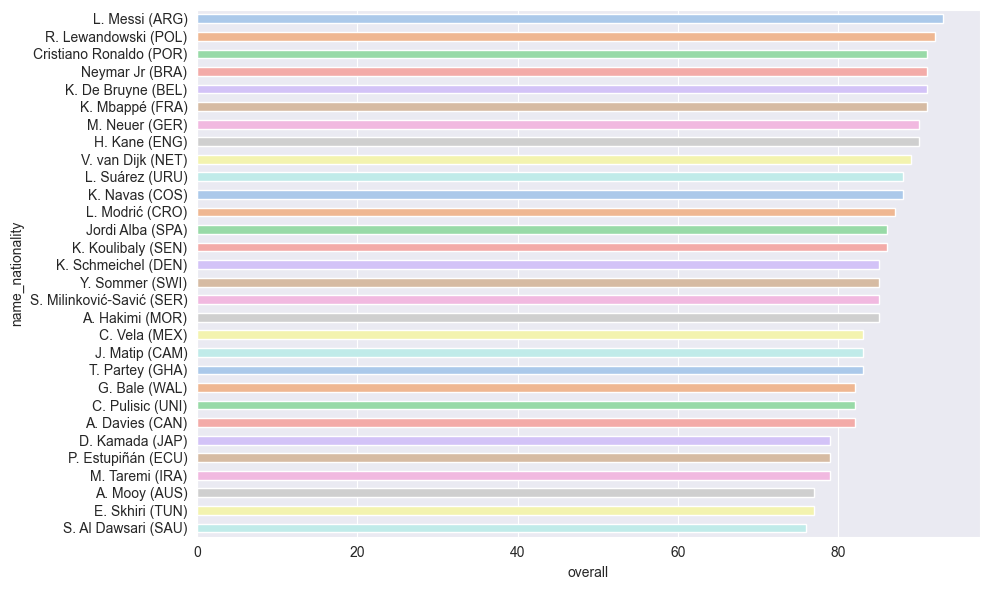

In [68]:
df_best_players = df_players.copy()
df_best_players = df_best_players.drop_duplicates('nationality_name').reset_index(drop=True)
country_short =  df_best_players['nationality_name'].str.extract('(^\w{3})', expand=False).str.upper()
df_best_players['name_nationality'] = df_best_players['short_name'] +' (' + country_short + ')'

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

sns.barplot(df_best_players, x='overall', y='name_nationality',
            palette=sns.color_palette('pastel'), width=0.5)
plt.show()

In [69]:
#BEST SQUAD per TEAM

In [70]:
#BEST SQUAD FUCNTION:
def best_squad(nationality):
    df_best_squad = df_players.copy()
    df_best_squad = df_best_squad.groupby(['nationality_name', 'player_positions']).head(2)
    df_best_squad = df_best_squad[df_best_squad['nationality_name']==nationality].sort_values(['player_positions', 'overall', 'potential'], ascending=False)
    return df_best_squad

In [71]:
#EXAMPLES: Argentina, Brazil, England

In [72]:
best_squad('Brazil')

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
191,Gabriel Jesus,24,Brazil,83,87,Manchester City,52500000.0,150000.0,ST
268,Richarlison,24,Brazil,82,87,Everton,46500000.0,100000.0,ST
5069,Paolinho Leima,21,Brazil,70,70,Clube Atlético Mineiro,1700000.0,12000.0,RWB
8031,Jadenilson Baia,33,Brazil,67,67,Sport Club Corinthians Paulista,525000.0,9000.0,RWB
656,Rodrygo,20,Brazil,79,88,Real Madrid CF,38500000.0,115000.0,RW
646,David Neres,24,Brazil,79,83,Ajax,25000000.0,19000.0,RW
271,Raphinha,24,Brazil,82,87,Leeds United,46000000.0,89000.0,RM
318,Lucas Moura,28,Brazil,81,81,Tottenham Hotspur,26000000.0,105000.0,RM
311,Danilo,29,Brazil,81,81,Juventus,22500000.0,83000.0,RB
484,Maikel Catarino,25,Brazil,80,80,Sport Club Corinthians Paulista,21000000.0,33000.0,RB


In [73]:
best_squad('Argentina')

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
93,L. Martínez,23,Argentina,85,89,Inter,78000000.0,145000.0,ST
164,M. Icardi,28,Argentina,83,83,Paris Saint-Germain,37000000.0,120000.0,ST
2913,N. Molina,23,Argentina,73,81,Udinese Calcio,6500000.0,11000.0,RWB
5437,E. Meza,22,Argentina,70,76,Club Atlético Colón,2400000.0,6000.0,RWB
0,L. Messi,34,Argentina,93,93,Paris Saint-Germain,78000000.0,320000.0,RW
33,Á. Di María,33,Argentina,87,87,Paris Saint-Germain,49500000.0,160000.0,RW
412,E. Salvio,30,Argentina,80,80,Boca Juniors,20500000.0,23000.0,RM
617,E. Buendía,24,Argentina,79,84,Aston Villa,26500000.0,61000.0,RM
818,G. Montiel,24,Argentina,78,84,Sevilla FC,21000000.0,23000.0,RB
1083,F. Bustos,25,Argentina,77,80,Club Atlético Independiente,13000000.0,14000.0,RB


In [74]:
#Average of overall player ratings of all the players of each country.

In [75]:
average_overall = [best_squad(team)['overall'].mean() for team in teams_worldcup]

df_average_overall = pd.DataFrame({'Teams': teams_worldcup, 'AVG_Overall': average_overall})
df_average_overall = df_average_overall.dropna()
df_average_overall = df_average_overall.sort_values('AVG_Overall', ascending=False)
df_average_overall

,Teams,AVG_Overall
6,Spain,82.400000
7,Portugal,81.733333
5,England,81.700000
1,Brazil,81.666667
3,France,81.000000
4,Argentina,80.566667
11,Germany,80.433333
2,Belgium,79.034483
9,Netherlands,78.758621
8,Mexico,77.727273


In [76]:
#Barchart of the above outcome

D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\MASTERCLASSES\Python\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


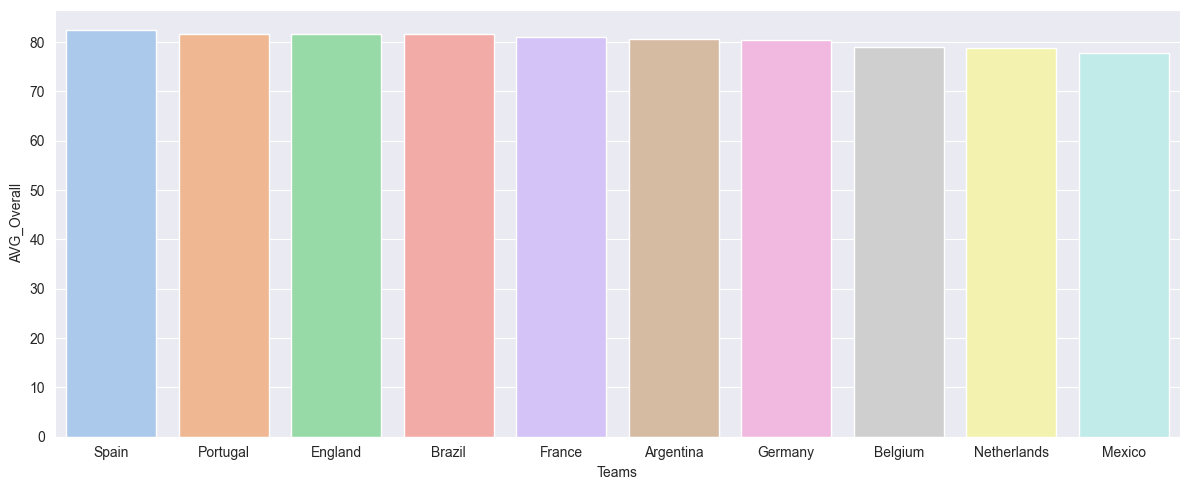

In [77]:
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

sns.barplot(df_average_overall[:10], x='Teams', y='AVG_Overall',
            palette=sns.color_palette('pastel'))
plt.show()

In [78]:
#Best Formation for each team

In [79]:
def best_lineup(nationality, lineup):
    lineup_count = [lineup.count(i) for i in lineup]

    df_lineup = pd.DataFrame({'position': lineup, 'count': lineup_count})
    positions_non_repeated = df_lineup[df_lineup['count'] <= 1]['position'].values
    positions_repeated = df_lineup[df_lineup['count'] > 1]['position'].values

    df_squad = best_squad(nationality)

    df_lineup = pd.concat([
        df_squad[df_squad['player_positions'].isin(positions_non_repeated)].drop_duplicates('player_positions', keep='first'),
        df_squad[df_squad['player_positions'].isin(positions_repeated)]]
    )
    return df_lineup[['short_name', 'overall', 'club_name', 'player_positions']]

In [80]:
#Dictionary of formations

In [81]:
dict_formation = {
    '4-3-3': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CAM', 'RW', 'ST', 'LW'],
    '4-4-2': ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'ST', 'ST'],
    '4-2-3-1': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'CAM', 'CAM', 'ST'],
}

In [82]:
#Formation and average of each country
for index, row in df_average_overall[:].iterrows():
    max_average = None
    for key, values in dict_formation.items():
        average = best_lineup(row['Teams'], values)['overall'].mean()
        if max_average is None or average>max_average:
            max_average = average
            formation = key
    print(row['Teams'], formation, max_average)

Spain 4-2-3-1 85.1
Portugal 4-2-3-1 84.9
England 4-4-2 84.45454545454545
Brazil 4-3-3 84.81818181818181
France 4-2-3-1 83.9
Argentina 4-3-3 83.54545454545455
Germany 4-2-3-1 84.1
Belgium 4-3-3 82.54545454545455
Netherlands 4-4-2 82.54545454545455
Mexico 4-3-3 78.6
Croatia 4-4-2 79.54545454545455
Uruguay 4-4-2 80.72727272727273
Serbia 4-3-3 77.81818181818181
Morocco 4-3-3 79.54545454545455
Denmark 4-2-3-1 78.8
Senegal 4-2-3-1 79.0
Switzerland 4-4-2 78.54545454545455
Japan 4-2-3-1 75.1
United States 4-3-3 76.18181818181819
Poland 4-4-2 78.18181818181819
Ghana 4-4-2 75.54545454545455
Cameroon 4-3-3 74.8
Ecuador 4-2-3-1 73.1
Wales 4-4-2 73.9090909090909
Costa Rica 4-2-3-1 74.83333333333333
Australia 4-4-2 72.72727272727273
Iran 4-4-2 72.375
Canada 4-2-3-1 74.25
Tunisia 4-3-3 71.0
Saudi Arabia 4-4-2 70.9090909090909


In [83]:
best_lineup('Brazil', dict_formation['4-3-3'])

,short_name,overall,club_name,player_positions
191,Gabriel Jesus,83,Manchester City,ST
656,Rodrygo,79,Real Madrid CF,RW
311,Danilo,81,Juventus,RB
3,Neymar Jr,91,Paris Saint-Germain,LW
153,Alex Sandro,83,Juventus,LB
18,Ederson,89,Manchester City,GK
190,Arthur,83,Juventus,CM
14,Casemiro,89,Real Madrid CF,CDM
189,Ronaldo Cabrais,83,Grêmio,CAM
39,Marquinhos,87,Paris Saint-Germain,CB


In [84]:
best_lineup('Spain', dict_formation['4-2-3-1'])

,short_name,overall,club_name,player_positions
59,Gerard Moreno,86,Villarreal CF,ST
87,Carvajal,85,Real Madrid CF,RB
50,Jordi Alba,86,FC Barcelona,LB
106,De Gea,84,Manchester United,GK
67,Rodri,86,Manchester City,CDM
52,Sergio Busquets,86,FC Barcelona,CDM
63,A. Laporte,86,Manchester City,CB
148,Azpilicueta,83,Chelsea,CB
72,David Silva,85,Real Sociedad,CAM
108,Luis Alberto,84,Lazio,CAM


In [85]:
best_lineup('Argentina', dict_formation['4-3-3'])

,short_name,overall,club_name,player_positions
93,L. Martínez,85,Inter,ST
0,L. Messi,93,Paris Saint-Germain,RW
818,G. Montiel,78,Sevilla FC,RB
171,L. Ocampos,83,Sevilla FC,LW
134,M. Acuña,84,Sevilla FC,LB
113,E. Martínez,84,Aston Villa,GK
247,R. De Paul,82,Atlético de Madrid,CM
206,É. Banega,82,Al Shabab,CDM
69,A. Gómez,85,Sevilla FC,CAM
269,C. Romero,82,Tottenham Hotspur,CB
